<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10>Artificial Intelligence and Machine Learning</center></font></h1>
<h1><center>Introduction to Natural Language Processing </center></h1>

<center><p float="center">
  <img src="https://images.pexels.com/photos/4185957/pexels-photo-4185957.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" width="720"/>
</p></center>

<center><font size=6>News Article Categorization</font></center>

## **Problem Statement**

### Business Context

In the dynamic landscape of the media and news industry, the ability to swiftly categorize and curate content has become a strategic imperative. The vast volume of information demands efficient systems to organize and present content to the audience.

The media industry, being the pulse of information dissemination, grapples with the continuous influx of news articles spanning diverse topics. Ensuring that the right articles reach the right audience promptly is not just a logistical necessity but a critical component in retaining and engaging audiences in an age of information overload.

Common Industry Challenges:
Amidst the ceaseless flow of news, organizations encounter challenges such as:
- Information Overload: The sheer volume of news articles makes manual categorization impractical.
- Timeliness: Delays in categorizing news articles can result in outdated or misplaced content.

### Problem Definition

E-news Express, a news aggregation startup, faces the challenge of categorizing the news articles collected. With news articles covering sports, busie=ness, politics, and more, the need for an advanced and automated system to categorize them has become increasingly evident. The manual efforts required for categorizing such a diverse range of news articles are substantial, and human errors in the categorization of news articles can lead to reputational damage for the startup. There is also the factor of delays and potential inaccuracies. To streamline and optimize this process, the organization recognizes the imperative of adopting cutting-edge technologies, particularly machine learning, to automate and enhance the categorization of content.

As a data scientist on the E-news Express data team, the task is to analyze the text in news articles and build a model for categorizing them. The goal is to optimize the categorization process, ensuring timely and personalized delivery.

### Data Dictionary

- **Article**: The main body of the news article

## **Installing and Importing Necessary Libraries and Dependencies**

In [ ]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 32.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

import pickle
# to split the data
from sklearn.model_selection import train_test_split
# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,make_scorer,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/article_data.csv")

## **Data Overview**

In [ ]:
data.head()

,Article,Category
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",0
1,Hassan: #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,0
2,"Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about 12 weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",0
3,"Prince Charles chastised for quot;old fashioned quot; views A minister has launched a scathing attack on heir to the throne Prince Charles, accusing him of being quot;very old fashioned quot; and out of touch in his views on teaching in schools.",0
4,"U.S. Says N.Korea Blast Probably Not Nuclear SEOUL (Reuters) - A huge explosion rocked North Korea last week but U.S. and South Korean officials said on Sunday it was unlikely to have been a nuclear weapons test despite the appearance of a ""peculiar cloud"" over the area.",0


In [ ]:
data.shape

(4000, 2)

* There are 4000 rows and 2 columns

In [ ]:
data["Category"].value_counts()

0    1000
1    1000
2    1000
3    1000
Name: Category, dtype: int64

* All the categories have 1000 rows each

## **Exploratory Data Analysis (EDA)**


In [ ]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Distribution of category

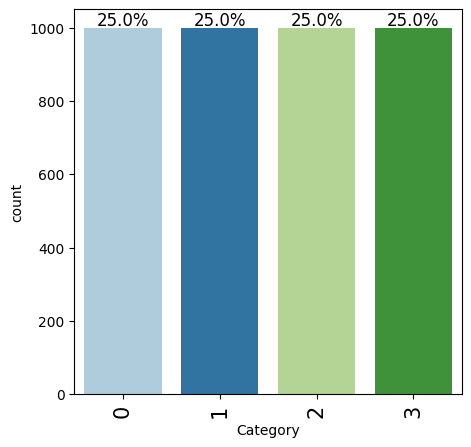

In [ ]:
labeled_barplot(data, "Category", perc=True)

* All categories have an equal number of articles.

## **Model Building - Sentence Transformer + ML**

### Defining the SentenceTransformer Model

In [ ]:
#Defining the model.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Encoding the data

In [ ]:
#Encoding the dataset.
embedding_matrix = model.encode(data["Article"],show_progress_bar=True,device="cuda" if torch.cuda.is_available() else "cpu")

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
#Saving the embedding matrix to the disk.
with open("embedding_matrix","wb") as f:
     pickle.dump(embedding_matrix,f)

In [ ]:
#Loading the embedding matrix from the disk.
with open("embedding_matrix","rb") as f:
     embedding_matrix = pickle.load(f)

### Train-Test Split

In [ ]:
X = embedding_matrix
y = data["Category"]

In [ ]:
# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

### Random Forest Model (base)

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
# Building the model
rf = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

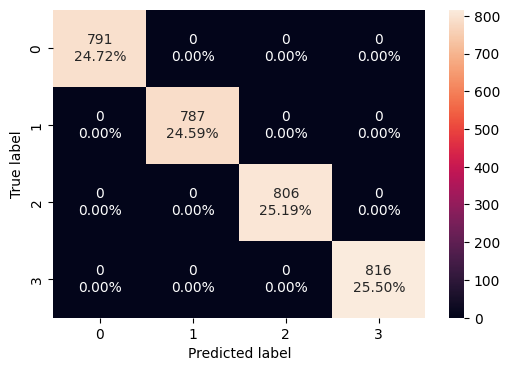

In [ ]:
confusion_matrix_sklearn(rf, X_train, y_train)

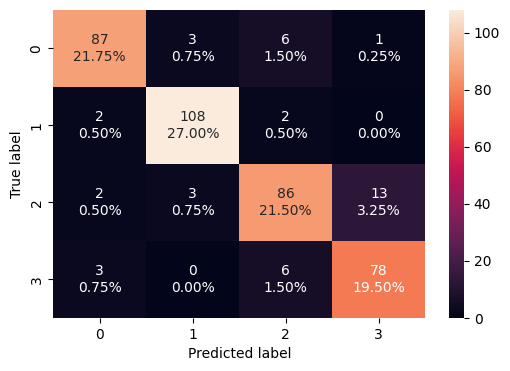

In [ ]:
confusion_matrix_sklearn(rf, X_valid, y_valid)

In [ ]:
# Predicting on train data
y_pred_train = rf.predict(X_train)

# Predicting on validation data
y_pred_valid = rf.predict(X_valid)

**Classification report**

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



* The model achieves perfect precision, recall, and F1-score (1.00) on all four classes (0 to 3) in the training set, indicating a strong ability to correctly classify instances.

In [ ]:
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        97
           1       0.95      0.96      0.96       112
           2       0.86      0.83      0.84       104
           3       0.85      0.90      0.87        87

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



* Performance on the validation set is slightly lower, with lower scores in precision, recall, and F1-score for all classes. This suggests a potential challenge in generalizing to new, unseen data.

In [ ]:
rf_train_perf = model_performance_classification_sklearn(
    rf, X_train, y_train
)

In [ ]:
rf_valid_perf = model_performance_classification_sklearn(
    rf, X_valid, y_valid
)

### Random Forest (with class_weights)

In [ ]:
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

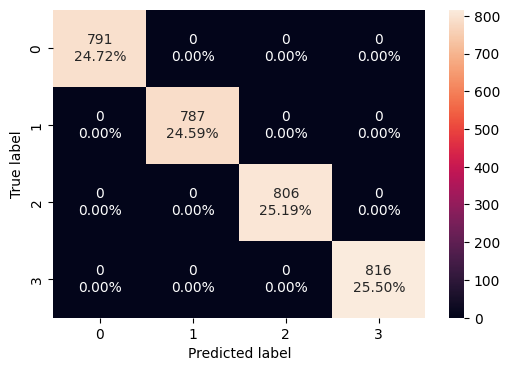

In [ ]:
confusion_matrix_sklearn(rf_balanced, X_train, y_train)

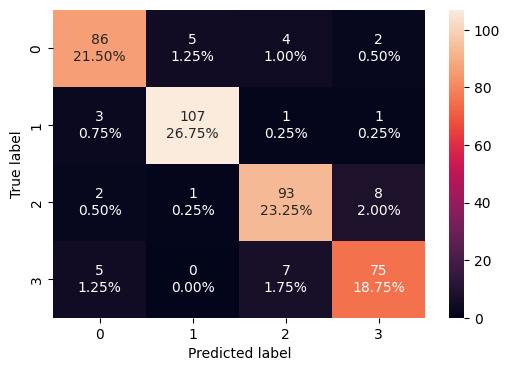

In [ ]:
confusion_matrix_sklearn(rf_balanced, X_valid, y_valid)

In [ ]:
# Predicting on train data
y_pred_train = rf_balanced.predict(X_train)

# Predicting on test data
y_pred_valid = rf_balanced.predict(X_valid)

**Classification report**

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        97
           1       0.95      0.96      0.95       112
           2       0.89      0.89      0.89       104
           3       0.87      0.86      0.87        87

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



- The model's performance has degraded slightly, and it is clear that overfitting is occurring as the model struggles to generalize on the validation dataset.
- We will now proceed to tune the model.







In [ ]:
rf_bal_train_perf = model_performance_classification_sklearn(
    rf_balanced, X_train, y_train
)

In [ ]:
rf_bal_valid_perf = model_performance_classification_sklearn(
    rf_balanced, X_valid, y_valid
)

### Random Forest (with hyperparamter tuning)

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 10, 3)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6],
    "n_estimators": np.arange(30, 110, 15),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
# Creating a new model with the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=6, n_estimators=105, random_state=42)

**Confusion Matrix**

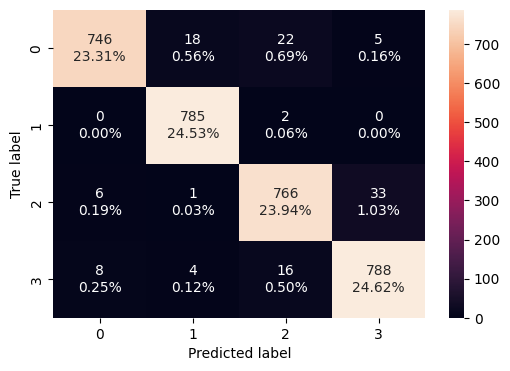

In [ ]:
confusion_matrix_sklearn(rf_tuned, X_train, y_train)

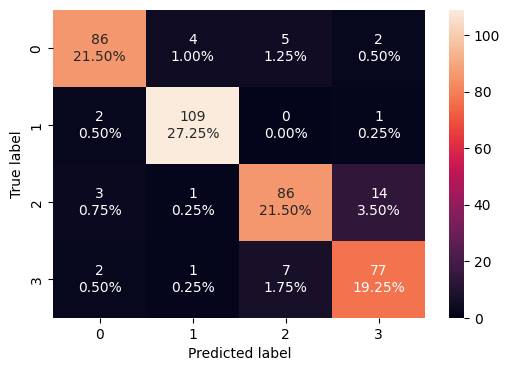

In [ ]:
confusion_matrix_sklearn(rf_tuned, X_valid, y_valid)

In [ ]:
# Predicting on train data
y_pred_train = rf_tuned.predict(X_train)

# Predicting on validation data
y_pred_valid = rf_tuned.predict(X_valid)

**Classification report**

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       791
           1       0.97      1.00      0.98       787
           2       0.95      0.95      0.95       806
           3       0.95      0.97      0.96       816

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200



* The model performs well on the training set with high precision, recall, and F1-score for all classes (0 to 3). The overall accuracy of 0.96 indicates that the model correctly classifies instances in the training data 96% of the time.

In [ ]:
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        97
           1       0.95      0.97      0.96       112
           2       0.88      0.83      0.85       104
           3       0.82      0.89      0.85        87

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.89       400



* While the validation set performance is still relatively good, there is a slight drop in precision, recall, and F1-score compared to the training set. This suggests that the model might face some challenges when applied to new, unseen data.

In [ ]:
rf_tuned_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)

In [ ]:
rf_tuned_valid_perf = model_performance_classification_sklearn(
    rf_tuned, X_valid, y_valid
)

## **Model Building - Transformer**

### Target Mapping

In [ ]:
class_map = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}

In [ ]:
class_map

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
reverse_class_map = {}
for key,value in class_map.items():
    reverse_class_map[value]=key

reverse_class_map

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

### Defining the Tokenizer

In [ ]:
## Initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Defining the Model

In [ ]:
## Initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Functions for making predictions

In [ ]:
# defining a function to compute different metrics.

def model_performance_classification(pred, target):
    """
    Function to compute different metrics to check classification model performance

    pred : prediction of the target variable.
    target: dependent variable
    """


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['World','Sports','Business','Sci/Tech']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# defining a function to generate, process, and return a response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In [ ]:
# checking a customer review and it's sentiment
print('Article:\t', data.iloc[4]["Article"])
print('Actual Category:\t', class_map[y[4]])

Article:	 U.S. Says N.Korea Blast Probably Not Nuclear  SEOUL (Reuters) - A huge explosion rocked North Korea last  week but U.S. and South Korean officials said on Sunday it was  unlikely to have been a nuclear weapons test despite the  appearance of a "peculiar cloud" over the area.
Actual Category:	 World


### Base Prompt for Prediction

In [ ]:
## Defining a prompt which tells the model what to do
sys_prompt = """
    Tag the given news article using one of the below mentioned categories only and not any other depending upon the content of the article:
    - World
    - Sports
    - Business
    - Sci/Tech
    Return World for World, Sports for Sports , Business for Business and Sci/Tech for Sci/Tech
"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (3378 > 512). Running this sequence through the model will result in indexing errors


World


In [ ]:
## Defining a function to generate a sentiment prediction
def predict_category(news_article):
    pred = generate_response(
        """
            {}
            news article: '{}'
        """.format(sys_prompt,news_article)
    )

    if "Sports" in pred:
       pred="Sports"
    elif "Business" in pred:
       pred="Business"
    elif "World" in pred:
       pred="World"
    else:
      pred="Sci/Tech"

    return reverse_class_map[pred]

In [ ]:
## Selecting and assigning specific columns
X_train = data.iloc[y_train.index]["Article"]
X_valid = data.iloc[y_test.index]["Article"]
X_test = data.loc[y_valid.index]["Article"]

In [ ]:
## Applying predict_category function on the train and validation data
y_pred_train_flan = X_train.apply(predict_category)
y_pred_valid_flan = X_valid.apply(predict_category)

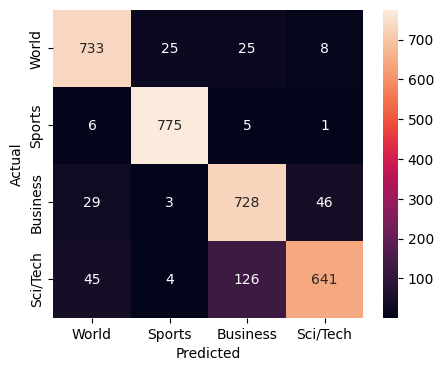

In [ ]:
## Plotting the confusion matrix
plot_confusion_matrix(y_train, y_pred_train_flan)

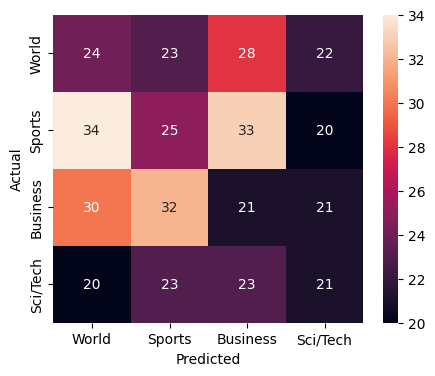

In [ ]:
## Plotting the confusion matrix
plot_confusion_matrix(y_valid, y_pred_valid_flan)

In [ ]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       791
           1       0.96      0.98      0.97       787
           2       0.82      0.90      0.86       806
           3       0.92      0.79      0.85       816

    accuracy                           0.90      3200
   macro avg       0.90      0.90      0.90      3200
weighted avg       0.90      0.90      0.90      3200



In [ ]:
## Getting the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan))

              precision    recall  f1-score   support

           0       0.22      0.25      0.23        97
           1       0.24      0.22      0.23       112
           2       0.20      0.20      0.20       104
           3       0.25      0.24      0.25        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.23      0.23      0.23       400



* The model exhibits poor generalization to new, unseen data, as evidenced by low precision, recall, and F1-score in the validation set. The overall accuracy of 0.23 indicates a significant drop in performance compared to the training set, suggesting that the model struggles with the validation data.

In [ ]:
## Storing the metrics
flan_train_base = model_performance_classification(y_pred_train_flan,y_train)
flan_valid_base = model_performance_classification(y_pred_valid_flan,y_valid)

### Improving Model Performance

In [ ]:
# defining a prompt which tells the model what to do
sys_prompt = """
Given a news article, use machine learning to categorize it into one of the following predefined categories:
- World
- Sports
- Business
- Sci/Tech

Consider the content of the article and provide additional details for a more accurate classification. Look for keywords, phrases, or context that indicate the primary focus of the article.

For example:
- If the article discusses international affairs, conflicts, or major global events, classify it as World.
- If the article is centered around sports events, teams, or athletes, classify it as Sports.
- For article covering financial news, markets, companies, or economic trends, assign the Business category.
- If the article emphasizes scientific discoveries, technological advancements, or innovations, categorize it as Sci/Tech.

"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

World


In [ ]:
y_pred_train_flan_imp = X_train.apply(predict_category)
y_pred_valid_flan_imp = X_valid.apply(predict_category)

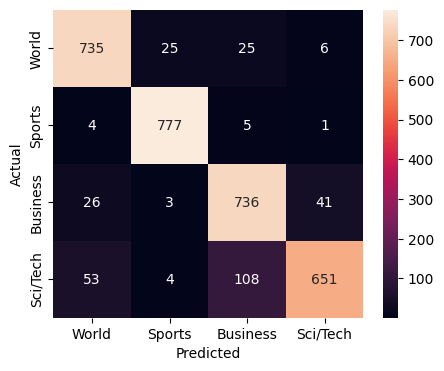

In [ ]:
plot_confusion_matrix(y_train, y_pred_train_flan_imp)

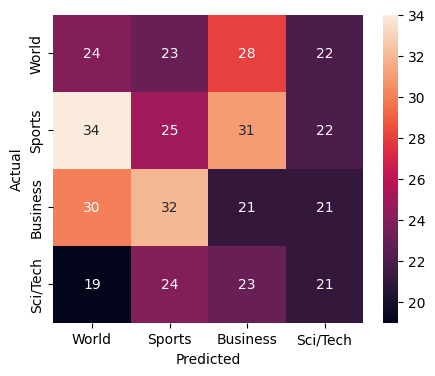

In [ ]:
plot_confusion_matrix(y_valid, y_pred_valid_flan_imp)

In [ ]:
print(classification_report(y_train, y_pred_train_flan_imp))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       791
           1       0.96      0.99      0.97       787
           2       0.84      0.91      0.88       806
           3       0.93      0.80      0.86       816

    accuracy                           0.91      3200
   macro avg       0.91      0.91      0.91      3200
weighted avg       0.91      0.91      0.91      3200



In [ ]:
print(classification_report(y_valid, y_pred_valid_flan_imp))

              precision    recall  f1-score   support

           0       0.22      0.25      0.24        97
           1       0.24      0.22      0.23       112
           2       0.20      0.20      0.20       104
           3       0.24      0.24      0.24        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.23      0.23      0.23       400



In [ ]:
flan_train_imp = model_performance_classification(y_pred_train_flan_imp,y_train)
flan_valid_imp = model_performance_classification(y_pred_valid_flan_imp,y_valid)

## **Model Performance Comparison and Final Model Selection**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_train_perf.T,
        rf_bal_train_perf.T,
        rf_tuned_train_perf.T,
        flan_train_base.T,
        flan_train_imp.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (Base prompt)",
    "Flan (Improvised prompt)"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (Base prompt),Flan (Improvised prompt)
Accuracy,1.0,1.0,0.964063,0.899062,0.905937
Recall,1.0,1.0,0.964063,0.899062,0.905937
Precision,1.0,1.0,0.964215,0.901325,0.907910
F1,1.0,1.0,0.963992,0.898280,0.905138


In [ ]:
# validation set performance comparison
models_valid_comp_df = pd.concat(
    [
        rf_valid_perf.T,
        rf_bal_valid_perf.T,
        rf_tuned_valid_perf.T,
        flan_valid_base.T,
        flan_valid_imp.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (Base prompt)",
    "Flan (Improvised prompt)"
]
print("Validation set performance comparison:")
models_valid_comp_df

Validation set performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (Base prompt),Flan (Improvised prompt)
Accuracy,0.897500,0.902500,0.895000,0.227500,0.227500
Recall,0.897500,0.902500,0.895000,0.227500,0.227500
Precision,0.897707,0.902338,0.895967,0.228225,0.227820
F1,0.897296,0.902396,0.894866,0.227567,0.227431


- The models "Random Forest (base)" and "Random Forest with class_weights" exhibit high accuracy (1.0) on the training set, indicating perfect classification. However, this might be a sign of overfitting, especially if the same models perform differently on the validation set.

- The "Random Forest (tuned)" model has a slightly lower accuracy on the training set (0.964063), but it is still quite high. On the validation set, it maintains a relatively high accuracy (0.895000), suggesting good generalization performance.

The "Random Forest (tuned)" model seems to strike a good balance between accuracy and generalization, making it a strong candidate for model selection.

In [ ]:
X_test = embedding_matrix[y_test.index]

None


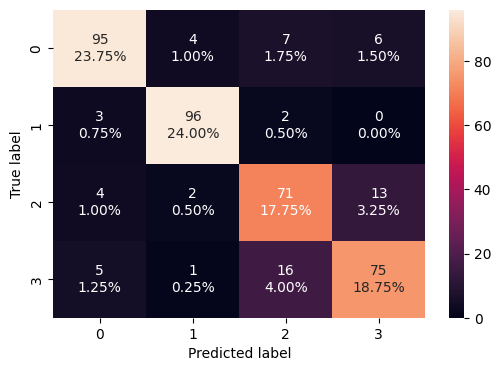

In [ ]:
print(confusion_matrix_sklearn(rf_tuned, X_test, y_test))

In [ ]:
# Predicting on test data
y_pred_test = rf_tuned.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       112
           1       0.93      0.95      0.94       101
           2       0.74      0.79      0.76        90
           3       0.80      0.77      0.79        97

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



- The model achieved aan accuracy of 84% on the test dataset.

## **Actionable Insights and Recommendations**

* Deploy the "Random Forest (tuned)" model for categorizing news articles in a production environment, as it has demonstrated strong performance on both the training and validation sets.

* Implement the categorization model in a real-time system to ensure timely delivery of news articles. This can be especially crucial in the fast-paced media industry where delays in categorization may lead to outdated or misplaced content.

* Enhance the user interface of E-news Express with category filters. Allow users to easily navigate and explore news articles within their preferred categories. A user-friendly interface contributes to a positive user experience.

* Implement a monitoring system to track the model's performance over time. This includes regularly assessing accuracy, precision, recall, and F1 score to ensure ongoing effectiveness.